# About this Notebook

The goal of this notebook is to build a classifier to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

The notebook will start with simple bag-of-words and tf-idf features and use simple models like logistic regression and Naive Bayes to perform classification with these features. Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

We will then move on to deep learning approaches, using a combination of pretrained word embeddings and simple deep learning models like RNNs and 1D convolutions to do more benchmarking. 

Next, we will explore deep learning models that have 'memory' using LSTMs (Long Short Term Memory) and GRUs (Gated Recurrent Units). 

Finally, we will approach state of the art performance using pretrained models like BERT and xlnet.

For metrics, I will focus more on recall than precision as I believe finding all toxic comments is more important that mislabelling some nontoxic comments. In addition to recall, I will look at the confusion matrix and precision-recall curves. 

Credits:
https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

## Load data

In [2]:
train = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
#The following is a non-English dataset and won't be used presently
validation = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/validation.csv')
#The following is a non-English dataset and won't be used presently
test = pd.read_csv('jigsaw-multilingual-toxic-comment-classification/test.csv')

## EDA

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
id               223549 non-null object
comment_text     223549 non-null object
toxic            223549 non-null int64
severe_toxic     223549 non-null int64
obscene          223549 non-null int64
threat           223549 non-null int64
insult           223549 non-null int64
identity_hate    223549 non-null int64
dtypes: int64(6), object(2)
memory usage: 13.6+ MB


We will drop the other columns and approach this problem as a Binary Classification Problem and also we will have our exercise done on a smaller subsection of the dataset(only 12000 data points) to make it easier to train the models

In [5]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [6]:
train = train.loc[:10000,:]
train.comment_text[train.toxic==1][1:2].values

array(['Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'],
      dtype=object)

In [7]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(xtrain)
count_valid = count_vectorizer.transform(xvalid)


## Sanity Checks

In [8]:
sum(sum(count_train.A[:5]))
count_vectorizer.vocabulary_['hello']


13360

In [9]:
sum(count_train.A,0)


array([29, 75,  5, ...,  1,  1,  1])

## Train Naive Bayes Model

In [10]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, ytrain)
pred = nb_classifier.predict(count_valid)
pred_proba = nb_classifier.predict_proba(count_valid)
accuracy = metrics.accuracy_score(yvalid, pred)
print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
print("Accuracy Score: {0:0.2f}".format(accuracy))

[[1798    9]
 [ 103   91]]
Accuracy Score: 0.94


Average precision-recall score: 0.48


0.4783299329716585

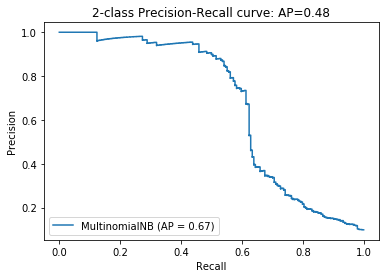

In [14]:
average_precision = metrics.average_precision_score(yvalid, pred)
#average_recall = metrics.recall_score(yvalid, pred)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
average_precision

## Use Tfidf for the features

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
count_train_idf = tfidf_vectorizer.fit_transform(xtrain)
count_valid_idf = tfidf_vectorizer.transform(xvalid)

In [16]:
max(count_train_idf.A[0])

0.5753045144327993

In [ ]:
metrics.confusion_matrix(yvalid, pred, labels=[0,1])

[[1807    0]
 [ 181   13]]
Accuracy Score: 0.91


Text(0.5,1,'2-class Precision-Recall curve: AP=0.16')

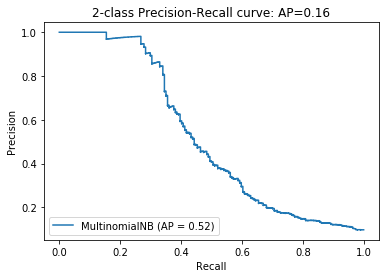

In [17]:
nb_classifier.fit(count_train_idf, ytrain)
pred = nb_classifier.predict(count_valid_idf)
pred_proba = nb_classifier.predict_proba(count_valid_idf)
accuracy = metrics.accuracy_score(yvalid, pred)
print(metrics.confusion_matrix(yvalid, pred, labels=[0,1]))
print("Accuracy Score: {0:0.2f}".format(accuracy))

average_precision = metrics.average_precision_score(yvalid, pred)

disp = metrics.plot_precision_recall_curve(nb_classifier, count_valid, yvalid)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Contents

In this Notebook I will start with the very Basics of RNN's and Build all the way to latest deep learning architectures to solve NLP problems. It will cover the Following:
* Simple RNN's
* Word Embeddings : Definition and How to get them
* LSTM's
* GRU's
* BI-Directional RNN's
* Encoder-Decoder Models (Seq2Seq Models)
* Attention Models
* Transformers - Attention is all you need
* BERT

I will divide every Topic into four subsections:
* Basic Overview
* In-Depth Understanding : In this I will attach links of articles and videos to learn about the topic in depth
* Code-Implementation
* Code Explanation

This is a comprehensive kernel and if you follow along till the end , I promise you would learn all the techniques completely

Note that the aim of this notebook is not to have a High LB score but to present a beginner guide to understand Deep Learning techniques used for NLP. Also after discussing all of these ideas , I will present a starter solution for this competiton

### Data Preparation

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


# Configuring TPU's

For this version of Notebook we will be using TPU's as we have to built a BERT Model

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Before We Begin

Before we Begin If you are a complete starter with NLP and never worked with text data, I am attaching a few kernels that will serve as a starting point of your journey
* https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
* https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

If you want a more basic dataset to practice with here is another kernel which I wrote:
* https://www.kaggle.com/tanulsingh077/what-s-cooking

Below are some Resources to get started with basic level Neural Networks, It will help us to easily understand the upcoming parts
* https://www.youtube.com/watch?v=aircAruvnKk&list=PL_h2yd2CGtBHEKwEH5iqTZH85wLS-eUzv
* https://www.youtube.com/watch?v=IHZwWFHWa-w&list=PL_h2yd2CGtBHEKwEH5iqTZH85wLS-eUzv&index=2
* https://www.youtube.com/watch?v=Ilg3gGewQ5U&list=PL_h2yd2CGtBHEKwEH5iqTZH85wLS-eUzv&index=3
* https://www.youtube.com/watch?v=tIeHLnjs5U8&list=PL_h2yd2CGtBHEKwEH5iqTZH85wLS-eUzv&index=4

For Learning how to visualize test data and what to use view:
* https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model
* https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

# Simple RNN

## Basic Overview

What is a RNN?

Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

Why RNN's?

https://www.quora.com/Why-do-we-use-an-RNN-instead-of-a-simple-neural-network

## In-Depth Understanding

* https://medium.com/mindorks/understanding-the-recurrent-neural-network-44d593f112a2
* https://www.youtube.com/watch?v=2E65LDnM2cA&list=PL1F3ABbhcqa3BBWo170U4Ev2wfsF7FN8l
* https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html

## Code Implementation

So first I will implement the and then I will explain the code step by step

### We will check the maximum number of words that can be present in a comment , this will help us in padding later

In [ ]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

Writing a function for getting auc score for validation

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc, fpr, tpr

In [ ]:
xtrain[0]
token = text.Tokenizer(num_words=None)
token
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

In [ ]:
len(xvalid_seq)
out = token.texts_to_sequences(['fuck'])

token.sequences_to_texts([[86]])
word_index['fucker']

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
xtrain[0]

In [ ]:
print(sum(ytrain))
ybaseline = [True if 86 in seq else False for seq in xtrain_pad]
sum(ybaseline)

In [ ]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=2, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's

In [ ]:
scores = model.predict(xvalid_pad)
score, fpr, tpr = roc_auc(scores,yvalid)
print("Auc: %.2f%%" % (score))
plt.plot(fpr, tpr)

In [ ]:
scores = model.predict(xtrain_pad)
score, fpr, tpr = roc_auc(scores,ytrain)
print("Auc: %.2f%%" % (score))
plt.plot(fpr, tpr)

In [ ]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,yvalid)})

## Code Explanantion
* Tokenization<br><br>
 So if you have watched the videos and referred to the links, you would know that in an RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1. <br>
  What keras Tokenizer does is , it takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.<br>
  Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now

In [ ]:
xtrain_seq[:1]

<b>Now you might be wondering What is padding? Why its done</b><br><br>

Here is the answer :
* https://www.quora.com/Which-effect-does-sequence-padding-have-on-the-training-of-a-neural-network
* https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
* https://www.coursera.org/lecture/natural-language-processing-tensorflow/padding-2Cyzs

Also sometimes people might use special tokens while tokenizing like EOS(end of string) and BOS(Begining of string). Here is the reason why it's done
* https://stackoverflow.com/questions/44579161/why-do-we-do-padding-in-nlp-tasks


The code token.word_index simply gives the dictionary of vocab that keras created for us

* Building the Neural Network

To understand the Dimensions of input and output given to RNN in keras her is a beautiful article : https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

The first line model.Sequential() tells keras that we will be building our network sequentially . Then we first add the Embedding layer.
Embedding layer is also a layer of neurons which takes in as input the nth dimensional one hot vector of every word and converts it into 300 dimensional vector , it gives us word embeddings similar to word2vec. We could have used word2vec but the embeddings layer learns during training to enhance the embeddings.
Next we add an 100 LSTM units without any dropout or regularization
At last we add a single neuron with sigmoid function which takes output from 100 LSTM cells (Please note we have 100 LSTM cells not layers) to predict the results and then we compile the model using adam optimizer 

* Comments on the model<br><br>
We can see our model achieves an accuracy of 1 which is just insane , we are clearly overfitting I know , but this was the simplest model of all ,we can tune a lot of hyperparameters like RNN units, we can do batch normalization , dropouts etc to get better result. The point is we got an AUC score of 0.82 without much efforts and we know have learnt about RNN's .Deep learning is really revolutionary

# Word Embeddings

While building our simple RNN models we talked about using word-embeddings , So what is word-embeddings and how do we get word-embeddings?
Here is the answer :
* https://www.coursera.org/learn/nlp-sequence-models/lecture/6Oq70/word-representation
* https://machinelearningmastery.com/what-are-word-embeddings/
<br> <br>
The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext. Without going into too much details, I would explain how to create sentence vectors and how can we use them to create a machine learning model on top of it and since I am a fan of GloVe vectors, word2vec and fasttext. In this Notebook, I'll be using the GloVe vectors. You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip or you can search for GloVe in datasets on Kaggle and add the file

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# LSTM's

## Basic Overview

Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

## In Depth Understanding

Why LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/PKMRR/vanishing-gradients-with-rnns
* https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

What are LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm
* https://distill.pub/2019/memorization-in-rnns/
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

# Code Implementation

We have already tokenized and paded our text for input to LSTM's

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,yvalid)})

## Code Explanation

As a first step we calculate embedding matrix for our vocabulary from the pretrained GLoVe vectors . Then while building the embedding layer we pass Embedding Matrix as weights to the layer instead of training it over Vocabulary and thus we pass trainable = False.
Rest of the model is same as before except we have replaced the SimpleRNN By LSTM Units

* Comments on the Model

We now see that the model is not overfitting and achieves an auc score of 0.96 which is quite commendable , also we close in on the gap between accuracy and auc .
We see that in this case we used dropout and prevented overfitting the data

# GRU's

## Basic  Overview

Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.

## In Depth Explanation

* https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
* https://www.coursera.org/learn/nlp-sequence-models/lecture/agZiL/gated-recurrent-unit-gru
* https://www.geeksforgeeks.org/gated-recurrent-unit-networks/

## Code Implementation

In [ ]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,yvalid)})

In [ ]:
scores_model

# Bi-Directional RNN's

## In Depth Explanation

* https://www.coursera.org/learn/nlp-sequence-models/lecture/fyXnn/bidirectional-rnn
* https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
* https://d2l.ai/chapter_recurrent-modern/bi-rnn.html

## Code Implementation

In [ ]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

In [ ]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

In [ ]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

In [ ]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})

## Code Explanation

Code is same as before,only we have added bidirectional nature to the LSTM cells we used before and is self explanatory. We have achieve similar accuracy and auc score as before and now we have learned all the types of typical RNN architectures

**We are now at the end of part 1 of this notebook and things are about to go wild now as we Enter more complex and State of the art models .If you have followed along from the starting and read all the articles and understood everything , these complex models would be fairly easy to understand.I recommend Finishing Part 1 before continuing as the upcoming techniques can be quite overwhelming**

# Seq2Seq Model Architecture

## Overview

RNN's are of many types  and different architectures are used for different purposes. Here is a nice video explanining different types of model architectures : https://www.coursera.org/learn/nlp-sequence-models/lecture/BO8PS/different-types-of-rnns.
Seq2Seq is a many to many RNN architecture where the input is a sequence and the output is also a sequence (where input and output sequences can be or cannot be of different lengths). This architecture is used in a lot of applications like Machine Translation, text summarization, question answering etc

## In Depth Understanding

I will not write the code implementation for this,but rather I will provide the resources where code has already been implemented and explained in a much better way than I could have ever explained.

* https://www.coursera.org/learn/nlp-sequence-models/lecture/HyEui/basic-models ---> A basic idea of different Seq2Seq Models

* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html , https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/ ---> Basic Encoder-Decoder Model and its explanation respectively

* https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639 ---> A More advanced Seq2seq Model and its explanation

* https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html , https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html ---> Implementation of Encoder-Decoder Model from scratch

* https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=8&t=0s ---> Introduction to Seq2seq By fast.ai

In [ ]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =results.Model,
    values = results.AUC_Score,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

# Attention Models

This is the toughest and most tricky part. If you are able to understand the intiuition and working of attention block , understanding transformers and transformer based architectures like BERT will be a piece of cake. This is the part where I spent the most time on and I suggest you do the same . Please read and view the following resources in the order I am providing to ignore getting confused, also at the end of this try to write and draw an attention block in your own way :-

* https://www.coursera.org/learn/nlp-sequence-models/lecture/RDXpX/attention-model-intuition --> Only watch this video and not the next one
* https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
* https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc
* https://distill.pub/2016/augmented-rnns/ 

## Code Implementation

* https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/ --> Basic Level
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html ---> Implementation from Scratch in Pytorch

# Transformers : Attention is all you need

So finally we have reached the end of the learning curve and are about to start learning the technology that changed NLP completely and are the reasons for the state of the art NLP techniques .Transformers were introduced in the paper Attention is all you need by Google. If you have understood the Attention models,this will be very easy , Here is transformers fully explained:

* http://jalammar.github.io/illustrated-transformer/

## Code Implementation

* http://nlp.seas.harvard.edu/2018/04/03/attention.html ---> This presents the code implementation of the architecture presented in the paper by Google

# BERT and Its Implementation on this Competition

As Promised I am back with Resiurces , to understand about BERT architecture , please follow the contents in the given order :-

* http://jalammar.github.io/illustrated-bert/ ---> In Depth Understanding of BERT

After going through the post Above , I guess you must have understood how transformer architecture have been utilized by the current SOTA models . Now these architectures can be used in two ways :<br><br>
1) We can use the model for prediction on our problems using the pretrained weights without fine-tuning or training the model for our sepcific tasks
* EG: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ ---> Using Pre-trained BERT without Tuning

2) We can fine-tune or train these transformer models for our task by tweaking the already pre-trained weights and training on a much smaller dataset
* EG:* https://www.youtube.com/watch?v=hinZO--TEk4&t=2933s ---> Tuning BERT For your TASK

We will be using the first example as a base for our implementation of BERT model using Hugging Face and KERAS , but contrary to first example we will also Fine-Tune our model for our task

Acknowledgements : https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras


Steps Involved :
* Data Preparation : Tokenization and encoding of data
* Configuring TPU's 
* Building a Function for Model Training and adding an output layer for classification
* Train the model and get the results

In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
# LOADING THE DATA

train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

Encoder FOr DATA for understanding waht encode batch does read documentation of hugging face tokenizer :
https://huggingface.co/transformers/main_classes/tokenizer.html here

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

## Tokenization

For understanding please refer to hugging face documentation again

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

In [ ]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

# End Notes

This was my effort to share my learnings so that everyone can benifit from it.As this community has been very kind to me and helped me in learning all of this , I want to take this forward. I have shared all the resources I used to learn all the stuff .Join me and make these NLP competitions your first ,without being overwhelmed by the shear number of techniques used . It took me 10 days to learn all of this , you can learn it at your pace and dont give in , at the end of all this you will be a different person and it will all be worth it.


### I am attaching more resources if you want NLP end to end:

1) Books

* https://d2l.ai/
* Jason Brownlee's Books

2) Courses

* https://www.coursera.org/learn/nlp-sequence-models/home/welcome
* Fast.ai NLP Course

3) Blogs and websites

* Machine Learning Mastery
* https://distill.pub/
* http://jalammar.github.io/

**<span style="color:Red">This is subtle effort of contributing towards the community, if it helped you in any way please show a token of love by upvoting**